In [1]:
# PyTorch and model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
from tqdm.notebook import tqdm
import numpy as np
import random

# TensorBoard
from torch.utils.tensorboard import SummaryWriter
import subprocess
import webbrowser
from datetime import datetime
import time

# File I/O
import os
from PIL import Image
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Human Motion Database 51 (HMDB51) Two-Stream Model (Combined Frames Model and Optical Flow Model)

## Define constants and set seed

In [2]:
# Training and evaluation
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
LEARNING_RATE_ADAPT_STEP = 2
LEARNING_RATE_ADAPT_GAMMA = 0.3
EPOCHS = 6
IMAGE_SIZE = (224, 224)
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {DEVICE}")

# Optical flow
OPTICAL_FLOW_SELECT = [0, 1, 2, 3, 4, 5, 6, 7]  # Frame selection for stack

# Two-Stream
OUT_FEATURES_CONV1X1 = 1024  # Features after 1x1 convolution on combined spatial and temporal features
DROPOUT_PROBABILITY = 0.2

# TensorBoard
TENSORBOARD_TRACKING = False
TENSORBOARD_NOT_OPEN = TENSORBOARD_TRACKING

# Seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


## Prepare dataset

### Load train, validation, and test splits

In [3]:
def input_list_from_file(file_path):
    list = []
    with open(file_path, "r") as f:
        for item in f:
            list.append(item.strip())
    return list

In [4]:
# Input training and validation set
train_val_files = input_list_from_file(os.path.join("HMDB51", "train_val_files.txt"))
train_val_labels = input_list_from_file(os.path.join("HMDB51", "train_val_labels.txt"))
train_files = input_list_from_file(os.path.join("HMDB51", "train_files.txt"))
train_labels = input_list_from_file(os.path.join("HMDB51", "train_labels.txt"))
val_files = input_list_from_file(os.path.join("HMDB51", "val_files.txt"))
val_labels = input_list_from_file(os.path.join("HMDB51", "val_labels.txt"))
# Input test set
test_files = input_list_from_file(os.path.join("HMDB51", "test_files.txt"))
test_labels = input_list_from_file(os.path.join("HMDB51", "test_labels.txt"))


# Map action categories to 0-11 labels
action_categories = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]
action_categories_map = {action: idx for idx, action in enumerate(action_categories)}
action_categories_map_inv = {idx: action  for idx, action in enumerate(action_categories)}
train_val_labels_mapped = [action_categories_map[label] for label in train_val_labels]
train_labels_mapped = [action_categories_map[label] for label in train_labels]
val_labels_mapped = [action_categories_map[label] for label in val_labels]
test_labels_mapped = [action_categories_map[label] for label in test_labels]

### Define data transformations for both streams

In [5]:
class SquarePad:
    def __call__(self, img):
        max_size = max(img.size)

        pad_left = (max_size - img.size[0]) // 2
        pad_top = (max_size - img.size[1]) // 2

        # Account for odd sizes
        pad_right = max_size - (img.size[0] + pad_left)
        pad_bottom = max_size - (img.size[1] + pad_top)

        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), 0, "constant")

In [6]:
train_val_transforms_spatial = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms_spatial = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_val_transforms_temporal = transforms.Compose([
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms_temporal = transforms.Compose([
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define custom dataset and create data loaders

In [7]:
class HMDB51TwoStreamDataset(Dataset):
    def __init__(self, files, labels, labels_map,
                 frames_spatial_path, frames_temporal_path, frames_temporal_select,
                 transform_spatial=None, transform_temporal=None):
        self.files = files
        self.labels = labels
        self.labels_map = labels_map
        self.frames_spatial_path = frames_spatial_path
        self.frames_temporal_path = frames_temporal_path
        self.frames_temporal_select = frames_temporal_select
        self.transform_spatial = transform_spatial
        self.transform_temporal = transform_temporal

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        label = self.labels[index]

        frames_label = self.labels_map[label]
        file_name = self.files[index]
        file_split = file_name.split(".")[0]

        # Spatial frame
        frame_spatial_name = file_split + "_middle.png"
        frame_spatial_path = os.path.join(self.frames_spatial_path, frames_label, frame_spatial_name)
        frame_spatial = Image.open(frame_spatial_path).convert("RGB")
        if self.transform_spatial:
            frame_spatial = self.transform_spatial(frame_spatial)

        # Optical flow frame stack
        frames_temporal = []
        for frame_temporal_idx in self.frames_temporal_select:
            frame_temporal_name = file_split + "_" + str(frame_temporal_idx) + ".png"
            frame_temporal_path = os.path.join(self.frames_temporal_path, frames_label, frame_temporal_name)
            frame_temporal = Image.open(frame_temporal_path).convert("RGB")
            if self.transform_temporal:
                frame_temporal = self.transform_temporal(frame_temporal)
            frames_temporal.append(frame_temporal)
        # Stack image channels
        if self.transform_temporal:
            frames_temporal = torch.cat(frames_temporal, dim=0)

        return frame_spatial, frames_temporal, label

In [8]:
frames_spatial_path = os.path.join("HMDB51", "frame_data")
frames_temporal_path = os.path.join("HMDB51", "optical_flow_data")

train_val_dataset = HMDB51TwoStreamDataset(train_val_files, train_val_labels_mapped,action_categories_map_inv,
                                           frames_spatial_path, frames_temporal_path, OPTICAL_FLOW_SELECT,
                                           transform_spatial=train_val_transforms_spatial,
                                           transform_temporal=train_val_transforms_temporal)
train_dataset = HMDB51TwoStreamDataset(train_files, train_labels_mapped,action_categories_map_inv,
                                       frames_spatial_path, frames_temporal_path, OPTICAL_FLOW_SELECT,
                                       transform_spatial=train_val_transforms_spatial,
                                       transform_temporal=train_val_transforms_temporal)
val_dataset = HMDB51TwoStreamDataset(val_files, val_labels_mapped,action_categories_map_inv,
                                     frames_spatial_path, frames_temporal_path, OPTICAL_FLOW_SELECT,
                                     transform_spatial=train_val_transforms_spatial,
                                     transform_temporal=train_val_transforms_temporal)
test_dataset = HMDB51TwoStreamDataset(test_files, test_labels_mapped,action_categories_map_inv,
                                     frames_spatial_path, frames_temporal_path, OPTICAL_FLOW_SELECT,
                                     transform_spatial=test_transforms_spatial,
                                     transform_temporal=test_transforms_temporal)

train_val_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define, train, and evaluate model with pre-trained weights for streams

## Load pre-trained HMDB51 Frames Model and Optical Flow Model and combine them into a two-stream model, fine-tune it, and evaluate it

### Load pre-trained models, combine them, and show summary

In [9]:
class TwoStreamModel(nn.Module):
    def __init__(self, spatial_model, temporal_model, out_features_conv1x1=512, dropout_p=0.2, num_classes=12):
        super(TwoStreamModel, self).__init__()

        # Features each model will be contributing
        in_features_spatial = spatial_model.fc.in_features
        in_features_temporal = temporal_model.fc.in_features

        # Remove layers from ends of models
        # Remove average pooling, dropout, and fc layer from spatial model
        self.SpatialStream = nn.Sequential(*(list(spatial_model.children())[:-3]))
        # Remove average pooling and fc layer from temporal model
        self.TemporalStream = nn.Sequential(*(list(temporal_model.children())[:-2]))

        # Reduce combined features from models using 1x1 convolution
        self.conv1x1 = nn.Conv2d(in_features_spatial + in_features_temporal, out_features_conv1x1, kernel_size=1, stride=1, bias=False)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout and classification
        self.dropout = nn.Dropout(p=dropout_p)
        self.combinedfc = nn.Linear(out_features_conv1x1, num_classes)
        # Original fc layer from spatial stream
        self.fc = spatial_model.fc

    def forward(self, x1, x2):
        # Run inputs through model streams
        x1 = self.SpatialStream(x1)
        x2 = self.TemporalStream(x2)

        # Fusion stream spatial + temporal
        # Combine features from models
        x_combined = torch.cat((x1, x2), dim=1)

        # Reduce combined features from models using 1x1 convolution
        x_combined = self.conv1x1(x_combined)

        # Global average pooling
        x_combined = self.avgpool(x_combined)

        # Dropout and classification
        x_combined = torch.flatten(x_combined, 1)
        x_combined = self.dropout(x_combined)
        x_combined = self.combinedfc(x_combined)

        # Continued spatial stream
        # Global average pooling
        x1 = self.avgpool(x1)

        # Dropout and classification
        x1 = torch.flatten(x1, 1)
        x1 = self.dropout(x1)
        x1 = self.fc(x1)

        # Fuse classifcations with averaging
        x = (x_combined + x1) / 2

        return x

In [10]:
spatial_hmdb51 = torch.load(os.path.join("models", "spatial_hmdb51_middle.pt"))
temporal_hmdb51 = torch.load(os.path.join("models", "temporal_hmdb51.pt"))

twostream_hmdb51 = TwoStreamModel(spatial_hmdb51, temporal_hmdb51, OUT_FEATURES_CONV1X1, DROPOUT_PROBABILITY, len(action_categories))

summary(model=twostream_hmdb51, input_size=[(BATCH_SIZE, 3, *IMAGE_SIZE), (BATCH_SIZE, len(OPTICAL_FLOW_SELECT)*3, *IMAGE_SIZE)],
        col_width=20, col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"], verbose=0)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TwoStreamModel (TwoStreamModel)               [32, 3, 224, 224]    [32, 12]             --                   True
├─Sequential (SpatialStream)                  [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─BasicConv2d (0)                        [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    │    └─BatchNorm2d (bn)                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─MaxPool2d (1)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─BasicConv2d (2)                        [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv)                     [32, 64, 56, 56]     [32, 64, 56, 56]  

### Train and validate model

In [11]:
def train_twostream_model_multiclass(model, num_classes, train_loader, validation_loader=None, device="cpu", epochs=15, lr=0.001,
                                     adapt_lr="step", adapt_lr_step=5, adapt_lr_gamma=0.5, adapt_lr_max=-1,
                                     tensorboard_tracking=False, experiment_name="Multiclass Classification", model_name=None):
    """
    Trains a two-stream model for multiclass classification.

    :param model: model
    :param num_classes: number of classes
    :param train_loader: training data loader
    :param validation_loader: validation data loader, if None then no validation
    :param device: device choice
    :param epochs: number of epochs
    :param lr: learning rate
    :param adapt_lr: "step" to adapt learning rate after certain amount of steps,
                     "cyclical" to create cyclical learning rate schedule,
                     otherwise static learning rate
    :param adapt_lr_step: number of epochs to change learning rate after if adapt_lr is "step" or "cyclical"
    :param adapt_lr_gamma: learning rate adaptation gamma if adapt_lr is "step" or "cyclical"
    :param adapt_lr_max: max learning rate in cycle if adapt_lr is "cyclical" (base learning rate is set to lr),
                         if -1 then set to 10 times the base learning rate
    :param tensorboard_tracking: tracks training with TensorBoard if True
    :param experiment_name: experiment name for Tensorboard for when tensorboard_tracking is True
    :param model_name: model name for Tensorboard for when tensorboard_tracking is True,
                       if None then uses class name of model

    :return: returns model at best epoch, dictionary of training and validation results up to best epoch,
             and learning rates up to best epoch
    """
    global TENSORBOARD_NOT_OPEN

    # Experiment tracking setup using TensorBoard
    if tensorboard_tracking:
        # Initialize a TensorBoard writer for logging
        timestamp = datetime.now().strftime("%Y-%m-%d")
        if model_name is None:
            model_name = model.__class__.__name__
        os.makedirs("runs", exist_ok=True)
        writer = SummaryWriter(os.path.join("runs", timestamp, experiment_name, model_name))

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if adapt_lr == "cyclical":
        if adapt_lr_max == -1:
            adapt_lr_max = 10 * lr
        scheduler = CyclicLR(optimizer, step_size_up=adapt_lr_step, base_lr=lr, max_lr=adapt_lr_max,
                             scale_fn=lambda x: adapt_lr_gamma ** (x - 1), scale_mode="cycle", cycle_momentum=False)
    else:
        scheduler = StepLR(optimizer, step_size=adapt_lr_step, gamma=adapt_lr_gamma)
    # Define loss function
    loss_fn = nn.CrossEntropyLoss()
    # Define accuracy function
    accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes)

    # Move loss, accuracy, and model to the appropriate device
    loss_fn = loss_fn.to(device)
    accuracy_fn = accuracy_fn.to(device)
    model = model.to(device)

    history = {"train_loss":[], "val_loss":[], "train_acc": [], "val_acc": []}

    learning_rates = []

    best_val_acc = 0.0
    best_val_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0.0, 0.0

        # Iterating over batches of training data
        for X1, X2, y in train_loader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Set model to training mode
            model.train()

            # Forward pass to compute predictions
            y_pred = model(X1, X2)

            # Calculate the current batch loss and accuracy and aggregate
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_pred, y).item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backpropagate the loss
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Average training loss and accuracy over all batches
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        # Keep history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        # If running validation
        if validation_loader is not None:
            # Set model to evaluation mode
            model.eval()
            # Context manager for inference without gradient tracking
            with torch.inference_mode():
                # Iterating over batches of validation data
                for X1, X2, y in validation_loader:
                    X1, X2, y = X1.to(device), X2.to(device), y.to(device)

                    # Forward pass to compute predictions
                    y_pred = model(X1, X2)

                    # Calculate the current batch loss and accuracy and aggregate
                    val_loss += loss_fn(y_pred, y).item()
                    val_acc += accuracy_fn(y_pred, y).item()

            # Average validation loss and accuracy over all batches
            val_loss /= len(validation_loader)
            val_acc /= len(validation_loader)
            # Keep history
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            # Check if the validation accuracy and loss improved
            if val_acc > best_val_acc and val_loss < best_val_loss:
                best_val_acc = val_acc
                best_val_loss = val_loss
                # Save the best model state
                best_epoch = epoch
                best_model_state = model.state_dict()
        else:
            # Keep values at 0 if not running validation
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        if tensorboard_tracking:
            # Log training and validation loss and accuracy to TensorBoard
            writer.add_scalars(main_tag="Validation Accuracy", tag_scalar_dict={"/acc": val_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Validation Loss", tag_scalar_dict={"/loss": val_loss}, global_step=epoch)
            writer.add_scalars(main_tag="Train Accuracy", tag_scalar_dict={"/acc": train_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Train Loss", tag_scalar_dict={"/loss": train_loss}, global_step=epoch)

            if TENSORBOARD_NOT_OPEN:
                TENSORBOARD_NOT_OPEN = False
                subprocess.Popen(f"tensorboard --logdir=runs --port={6007}", shell=True)
                # Open a web browser tab, the time delay allows TensorBoard to start up
                time.sleep(5)
                webbrowser.open_new_tab("http://localhost:6007")

        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

        # Get epoch learning rate
        learning_rates.append(scheduler.get_last_lr())
        # Step scheduler for learning rate adaptation
        if adapt_lr == "step" or adapt_lr == "cyclical":
            scheduler.step()

    # Revert model to best state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        # Cut the history up to the best epoch
        history["train_loss"] = history["train_loss"][:best_epoch + 1]
        history["train_acc"] = history["train_acc"][:best_epoch + 1]
        history["val_loss"] = history["val_loss"][:best_epoch + 1]
        history["val_acc"] = history["val_acc"][:best_epoch + 1]
        learning_rates = learning_rates[:best_epoch + 1]

    if tensorboard_tracking:
        writer.close()

    return model, history, learning_rates

In [12]:
twostream_hmdb51, history_twostream_hmdb51, lrs_twostream_hmdb51 = train_twostream_model_multiclass(
    twostream_hmdb51, len(action_categories), train_loader, val_loader, DEVICE,
    EPOCHS, LEARNING_RATE, "step", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="twostream_hmdb51", model_name="twostream_hmdb51"
)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.40916| Train acc:  0.92839| Val loss:  0.90967| Val acc:  0.66250
Epoch: 1| Train loss:  0.13261| Train acc:  0.98047| Val loss:  0.82124| Val acc:  0.72083
Epoch: 2| Train loss:  0.06561| Train acc:  0.99479| Val loss:  0.81029| Val acc:  0.75000
Epoch: 3| Train loss:  0.04307| Train acc:  0.99740| Val loss:  0.80763| Val acc:  0.75000
Epoch: 4| Train loss:  0.04567| Train acc:  0.99531| Val loss:  0.81394| Val acc:  0.72292
Epoch: 5| Train loss:  0.03290| Train acc:  0.99870| Val loss:  0.76862| Val acc:  0.77083


### Plot accuracy and loss for training and validation

In [13]:
def plot_train_val_metrics(history, model_name="Model", file_name="results_model.png"):
    """
    Plots accuracy and loss for training and validation sets and outputs to file.

    :param history: dictionary of training and validation results
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", color="black")
    plt.plot(history["val_loss"], label="Validation Loss", color="red")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", color="black")
    plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}")

    # Adjust layout and show plot
    plt.tight_layout()

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

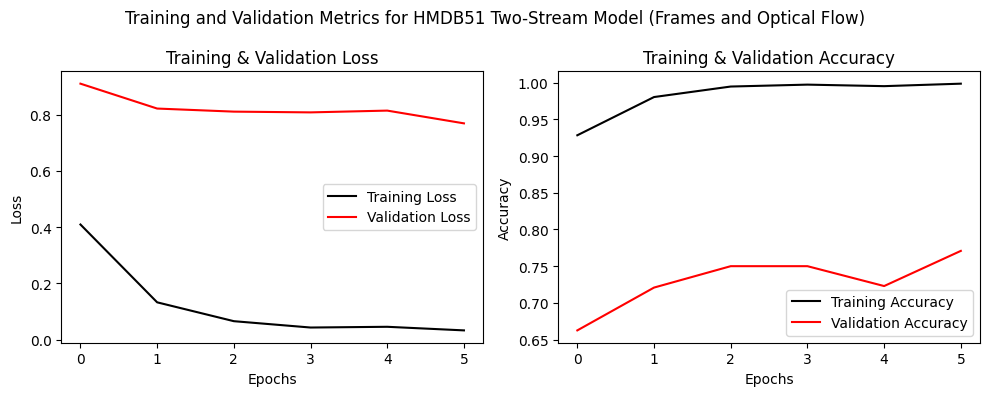

In [14]:
plot_train_val_metrics(history_twostream_hmdb51,
                       "HMDB51 Two-Stream Model (Frames and Optical Flow)", "results_twostream_hmdb51.png")

### Plot learning rate during training

In [15]:
def plot_lr(lr_per_epoch, model_name="Model", file_name="lrs_model.png"):
    """
    Plots learning rates for every epoch and outputs to file.

    :param lr_per_epoch: learning rate for every epoch
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Plot learning rate
    plt.figure(figsize=(6, 4))
    plt.plot(lr_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f"Adaptive Learning Rate During Training for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

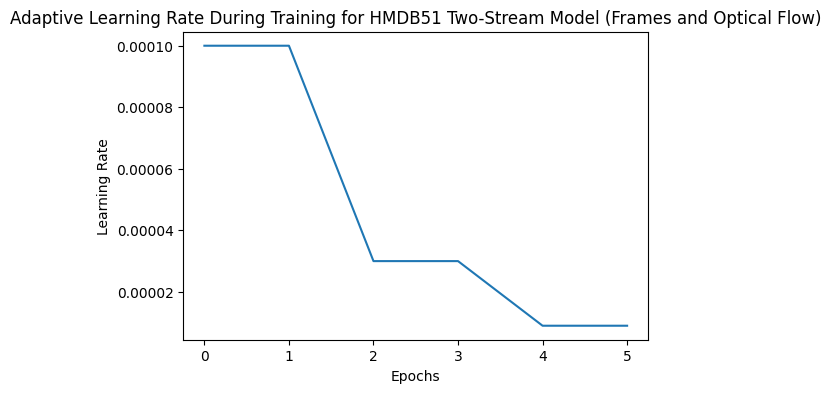

In [16]:
plot_lr(lrs_twostream_hmdb51, "HMDB51 Two-Stream Model (Frames and Optical Flow)", "lrs_twostream_hmdb51.png")

### Export model

In [17]:
def export_model(model, model_name="model", script=False):
    """
    Outputs model to file.

    :param model: model
    :param model_name: model name for output file name
    :param script: scripted model output if True
    """
    # Save model
    os.makedirs("models", exist_ok=True)
    if script:
        # Script model using TorchScript
        model_scripted = torch.jit.script(model)
        model_scripted.save(os.path.join("models", model_name + ".pt"))
    else:
        torch.save(model, os.path.join("models", model_name + ".pt"))

In [18]:
export_model(twostream_hmdb51, "twostream_hmdb51")

### Evalutate model on test set

In [19]:
def test_twostream_model_multiclass(model, num_classes, test_loader, device="cpu"):
    """
    Tests a trained two-stream multiclass classification model on test data.

    :param model: model
    :param num_classes: number of classes
    :param test_loader: test data loader
    :param device: device choice
    :return: returns test loss, test accuracy, predicted labels, and actual labels
    """
    # Define loss function
    loss_fn = nn.CrossEntropyLoss()
    # Define accuracy function
    accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes)

    # Move loss, accuracy, and model to the appropriate device
    loss_fn = loss_fn.to(device)
    accuracy_fn = accuracy_fn.to(device)
    model = model.to(device)

    test_loss, test_acc = 0, 0
    y_preds = []
    y_labels = []

    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # Iterating over batches of test data
        for X1, X2, y in test_loader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Forward pass to compute predictions
            y_pred = model(X1, X2)

            # Calculate the current batch loss and accuracy and aggregate
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy_fn(y_pred, y).item()

            # Store predictions and labels
            y_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
            y_labels.extend(y.cpu().numpy())

        # Average test loss and accuracy over all batches
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

    return test_loss, test_acc, y_preds, y_labels

In [20]:
test_loss_twostream_hmdb51, test_acc_twostream_hmdb51, y_preds_twostream_hmdb51, y_labels_twostream_hmdb51 \
    = test_twostream_model_multiclass(twostream_hmdb51, len(action_categories), test_loader, DEVICE)

Test loss:  0.93554| Test acc:  0.71094


### Plot confusion matrix

In [21]:
def plot_confusion_matrix(preds, labels, labels_map, model_name="Model", file_name="cm_model.png"):
    """
    Plots confusion matrix of predicted labels and actual labels and outputs to file.

    :param preds: predicted labels
    :param labels: actual labels
    :param labels_map: dictionary of labels mapped to numeric model labels
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Extract label names based on mapping
    label_names = [label for label, idx in labels_map.items()]

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title(f"Confusion Matrix for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

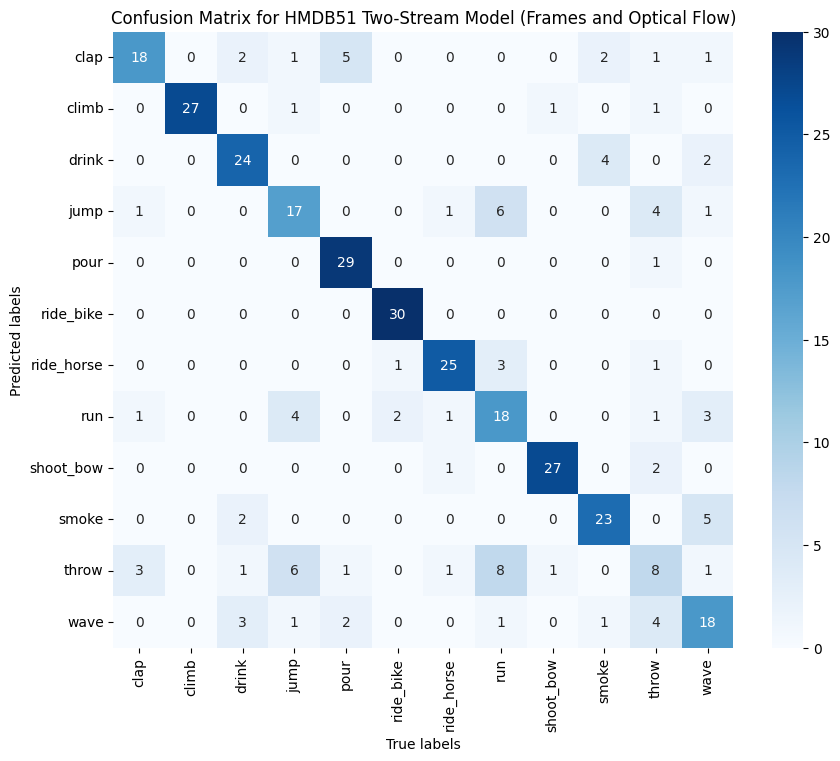

In [22]:
plot_confusion_matrix(y_preds_twostream_hmdb51, y_labels_twostream_hmdb51, action_categories_map,
                      "HMDB51 Two-Stream Model (Frames and Optical Flow)", "cm_twostream_hmdb51.png")

### Save model results

In [23]:
def export_model_metrics(model_metrics, file_name="metrics_model.csv"):
    """
    Outputs training, validation, and test results for multiple models to file.

    :param model_metrics: dictionary of dictionaries for every model with best epoch training and validation results
                          and final test results
    :param file_name: output file name
    """
    # Convert metrics to dataframe
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient="index")
    print(model_metrics_df)

    # Save dataframe
    os.makedirs("results", exist_ok=True)
    model_metrics_df.to_csv(os.path.join("results", file_name))

In [24]:
model_metrics = {
    "twostream_model_hmdb51": {
        "train_loss": history_twostream_hmdb51["train_loss"][-1],
        "val_loss": history_twostream_hmdb51["val_loss"][-1],
        "train_acc": history_twostream_hmdb51["train_acc"][-1],
        "val_acc": history_twostream_hmdb51["val_acc"][-1],
        "test_loss": test_loss_twostream_hmdb51,
        "test_acc": test_acc_twostream_hmdb51
    }
}

export_model_metrics(model_metrics, "metrics_twostream_hmdb51.csv")

                        train_loss  val_loss  train_acc   val_acc  test_loss  \
twostream_model_hmdb51    0.032902  0.768618   0.998698  0.770833   0.935538   

                        test_acc  
twostream_model_hmdb51  0.710938  
